In [1]:
IMAGE_SIZE = 224
NUM_CHANELLS = 1
LEN_FEATURES = IMAGE_SIZE*IMAGE_SIZE*NUM_CHANELLS
NUM_OF_EPOCHS = 50
ZISE_OF_IMAGES = 5000
CLASSES = ['happy', 'sad']
# DRIVE_PATH = '/content/drive'
# PATH = DRIVE_PATH + "/MyDrive/deep-learning/"
# PATH_TO_DATA = PATH + "data/images/"
# RES_PATH = PATH+"RES/"

PATH = r"D:\\Projects\Development\\courses_projects\\deep_learning_and_natural_language_processing\\dog-image-mood-classification"
PATH_TO_DATA = PATH + '\\' + "data\\images"
RES_PATH = r"results\\"

In [2]:
# from google.colab import drive
# drive.mount(DRIVE_PATH)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [3]:
# modeling
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
tf.disable_v2_behavior()
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# tools
import os
import glob
import random
import numpy as np
from datetime import datetime
import pytz
import sklearn as sk
from tqdm import tqdm

# others
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

c:\Users\kggol\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
def split_train_test(test_size: float, images, labels, files):
  size_of_train = round(len(images) * test_size)
  train_images = images[0: size_of_train]
  train_labels = labels[0: size_of_train]
  train_files = files[0: size_of_train]

  test_images = images[size_of_train: -1]
  test_labels = labels[size_of_train: -1]
  test_files = files[size_of_train: -1]

  return [train_images, train_labels, train_files], [test_images, test_labels, test_files]

def load_data(classes):
  images = []
  labels = []
  files = []
  for i in range(len(classes)):
    folder_name = classes[i]
    path = os.path.join(PATH_TO_DATA, folder_name, '*g')
    count = 0
    for file_index, file_name in enumerate(glob.glob(path)):
      image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
      image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
      images.append(image)
      label = [i]
      labels.append(label)
      files.append(os.path.basename(file_name))
      if count == ZISE_OF_IMAGES / 2:
        break
      count += 1

  return  images, labels, files

def normalise_data(data):
  data = data.astype(np.float32)
  for i in range(len(data)):
    for j in range(len(data[i])):
      data[i][j]/=255.0
  return data

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
    if cls_pred is not None:
        images, cls_true, cls_pred  = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    else:
        images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3))

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def make_vactors(labels):
  new_labels = []
  for label in labels:
      value = label[0]
      new_label = [0] * len(CLASSES)
      new_label[value] = 1
      new_labels.append(new_label)
  return new_labels

In [5]:
images, labels, files = load_data(CLASSES)
images, labels, files = shuffle(images, labels, files)  # shuffle the data

In [6]:
train, test = split_train_test(test_size=0.8, images=images, labels=labels, files=files)
train_images, train_labels, train_files = train[:]
test_images, test_labels, test_files = test[:]

In [7]:
# Train images & labels
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(f"Train images data shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

# Test images & labels
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(f"Test images data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images data shape: (4002, 224, 224)
Train labels shape: (4002, 1)
Test images data shape: (999, 224, 224)
Test labels shape: (999, 1)


In [8]:
input_layer = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE))
dense_layer_1 = tf.keras.layers.Dense(units=128, activation='relu')(input_layer)
dense_layer_2 = tf.keras.layers.Dense(units=512, activation='relu')(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(units=256, activation='relu')(dense_layer_2)
output_layer = tf.keras.layers.Flatten()(dense_layer_3)
output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(output_layer)

In [9]:
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224)]        0         
                                                                 
 dense (Dense)               (None, 224, 128)          28800     
                                                                 
 dense_1 (Dense)             (None, 224, 512)          66048     
                                                                 
 dense_2 (Dense)             (None, 224, 256)          131328    
                                                                 
 flatten (Flatten)           (None, 57344)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 57345     
                                                                 
Total params: 283,521
Trainable params: 283,521
Non-trainable

In [12]:
hist = model.fit(x=train_images, y=train_labels, epochs=NUM_OF_EPOCHS, batch_size=BATCH_SIZE)

Train on 4002 samples
Epoch 1/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 22.3654 - acc: 0.5067
Epoch 2/50
4002/4002 [==============================] - 8s 2ms/sample - loss: 0.6909 - acc: 0.5357
Epoch 3/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6812 - acc: 0.5502
Epoch 4/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6728 - acc: 0.5660
Epoch 5/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6667 - acc: 0.5717
Epoch 6/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6549 - acc: 0.5915
Epoch 7/50
4002/4002 [==============================] - 8s 2ms/sample - loss: 0.6448 - acc: 0.5995
Epoch 8/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6536 - acc: 0.5867
Epoch 9/50
4002/4002 [==============================] - 8s 2ms/sample - loss: 0.6364 - acc: 0.6074
Epoch 10/50
4002/4002 [==============================] - 9s 2ms/sample - loss: 0.6240 

In [13]:
# evaluate the model on the test data
loss, accuracy = model.evaluate(x=test_images, y=test_labels)

In [14]:
print(f"Loss of the test data: {loss:0.4f}")

Loss of the test data: 1.6247


In [15]:
print(f"Accuracy of the test data: {accuracy:0.4f}")


Accuracy of the test data: 0.5045


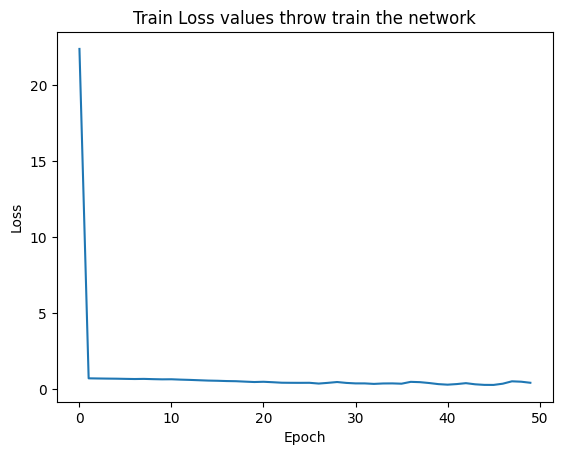

In [16]:
plt.title("Train Loss values throw train the network")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(NUM_OF_EPOCHS), hist.history['loss'])
plt.show()

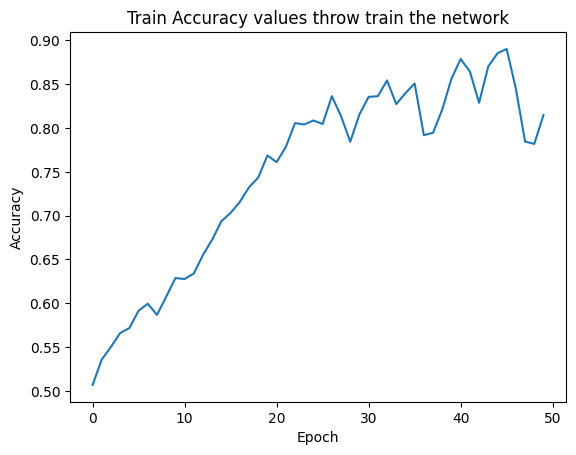

In [17]:
plt.title("Train Accuracy values throw train the network")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(np.arange(NUM_OF_EPOCHS), hist.history['acc'])
plt.show()